# Preprocessing spam data

In [2]:
!pip install nltk

  Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl.metadata (41 kB)
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 13.2 MB/s eta 0:00:00
Using cached regex-2024.11.6-cp311-cp311-win_amd64.whl (274 kB)


In [6]:
! pip install contractions

### Imports

In [77]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from collections import Counter

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import contractions
from gensim.models import Word2Vec

In [4]:
# # Download nltk data -- Need only once
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\H\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\H\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\H\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [33]:
# Sample data
RAW_DATA= 'spam_detection.csv'
MAX_VOCAB = 20000
RANDOM_STATE = 777

TRAIN = 'train.csv'
VAL = 'val.csv'
TEST = 'test.csv'

LABELS = ['Non-Spam', 'SPAM']
COLOURS = ['#22a6b3', '#eb4d4b']

X_TRAIN = 'x_train.npy' 
Y_TRAIN = 'y_train.npy'
X_VAL = 'x_val.npy'
Y_VAL = 'y_val.npy'
X_TEST = 'x_test.npy'
Y_TEST = 'y_test.npy'

### Core funtions 

In [41]:
def clean_text(t):
  txt = t.lower()
  txt = contractions.fix(txt) # handle contractions
  # Removals
  txt = re.sub(r'http\S+|www\S+|https\S+', '', txt, flags=re.MULTILINE ) # URLS
  txt = re.sub(r'[^\w\s]', '', txt) # punctuation
  txt = re.sub(r'\d+', '', txt) # numbers
  # tokenise
  txt = word_tokenize(txt)
  stop_words = set(stopwords.words('english'))
  txt = [word for word in txt if not word in stop_words]
  return txt


#Pie chart
def display_pie_chart(counts):
    plt.figure(figsize=(3, 3), dpi=180)
    plt.pie(counts,
            labels=LABELS,
            colors=COLOURS,
            textprops={'fontsize': 7},
            startangle=90,
            autopct='%1.0f%%',
            pctdistance=0.8,
            explode=[0.04, 0.04])
    centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')  #coordinates, radius, centre colour
    plt.gca().add_artist(centre_circle) # get current axis and add new circle to it
    
    plt.show()


def get_document_vector(tokens, model, vec_size=100):
  vectors = [vec_model.wv[token] for token in tokens if token in vec_model.wv]
  return np.mean(vectors, axis=0) if vectors else np.zeros(vec_size)



## Load data

In [27]:
data  = pd.read_csv(RAW_DATA, encoding='ISO-8859-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [28]:
data = data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1)
data.columns = ['temp', 'text']
data['label'] = data['temp'].map({'ham': 0, 'spam': 1})
data = data.astype({'label':'int16'})
data = data.astype({'text':'string'})
data.head()

,temp,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


### Explore data

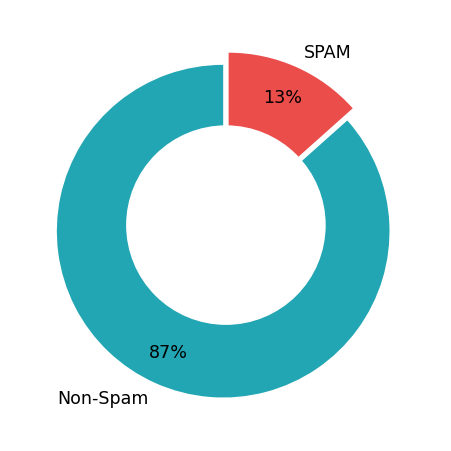

In [55]:
df = data
ham_count = (df['label'] == 0).sum()
spam_count = (df['label'] == 1).sum()
size = [ham_count, spam_count ]

display_pie_chart(counts=size)

### Balance data labels

In [67]:
# random shuffle 
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

In [68]:
# remove some non-spam to balance
majority_df = df[df['label'] == 0]
minority_df = df[df['label'] == 1]
remove = int(len(majority_df) * 0.5) # remove 50% of ham
downsampled_df = majority_df.sample(n=(len(majority_df) - remove), random_state=RANDOM_STATE)
downsampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2413 entries, 4253 to 1547
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   temp    2413 non-null   object
 1   text    2413 non-null   string
 2   label   2413 non-null   int16 
dtypes: int16(1), object(1), string(1)
memory usage: 61.3+ KB


In [69]:
balanced_df = pd.concat([downsampled_df, minority_df])
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3160 entries, 4253 to 5567
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   temp    3160 non-null   object
 1   text    3160 non-null   string
 2   label   3160 non-null   int16 
dtypes: int16(1), object(1), string(1)
memory usage: 80.2+ KB


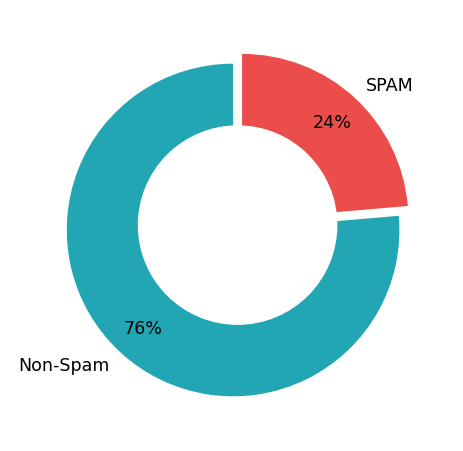

In [70]:
ham_count = (balanced_df['label'] == 0).sum()
spam_count = (balanced_df['label'] == 1).sum()
size = [ham_count, spam_count ]
display_pie_chart(counts=size)

### Tokenise texts

In [71]:
%%time
# make a token list by cleaning and stemming 
balanced_df['tokens']= balanced_df['text'].apply(clean_text)
balanced_df.head()

CPU times: total: 1.19 s
Wall time: 1.22 s


,temp,text,label,tokens
4253,ham,\HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...,0,"[hey, hey, werethe, monkeespeople, say, monkey..."
1181,ham,Sorry about that this is my mates phone and i ...,0,"[sorry, mates, phone, write, love, kate]"
1691,ham,U can call me now...,0,[call]
4146,ham,Hows the champ just leaving glasgow!,0,"[champ, leaving, glasgow]"
4525,ham,"Hi, can i please get a &lt;#&gt; dollar loan...",0,"[hi, please, get, ltgt, dollar, loan, ill, pay..."


In [72]:
balanced_df.to_csv('spam_cleaned.csv')

### Split data

In [73]:
# Split selecte columns
train, val_test = train_test_split(balanced_df[['label', 'tokens']], test_size=0.2, random_state=RANDOM_STATE)
val, test = train_test_split(val_test, test_size=0.5, random_state=RANDOM_STATE)
print(f'x_train shape: {train.shape}, val shape: {val.shape} test shape: {test.shape}')

x_train shape: (2528, 2), val shape: (316, 2) test shape: (316, 2)


In [74]:
train.head()

,label,tokens
2418,0,"[time, want, come]"
3136,1,"[join, uks, horniest, dogging, service, sex, n..."
4769,0,"[ok, thanx]"
2991,1,"[believe, true, incredible, txts, reply, g, le..."
1059,0,"[yup, next, stop]"


## Make word vector
using the training set only

In [75]:
# need all tokens from each set
train_tokens  = train['tokens'].tolist() # use this only for word2vec
val_tokens = val['tokens'].tolist()
test_tokens = test['tokens'].tolist()
print(f'all train tokens = {len(train_tokens)}, val tokens = {len(val_tokens)}, test tokens = {len(test_tokens)}')

all train tokens = 2528, val tokens = 316, test tokens = 316


In [79]:
%%time
# build word2vec vectoriser
vec_model = Word2Vec(sentences=train_tokens,
                    vector_size=100,
                    window=5,# distance from
                    min_count=2, # frequency of token
                    workers=4, # cpu nr
                    sg=1,
                    epochs=20,
                    seed=RANDOM_STATE) #skip gram for sentiment


CPU times: total: 1.78 s
Wall time: 918 ms


In [80]:
# save the w2v model
vec_model.save('spam_filter_word2vec.model')

In [81]:
%%time
x_train = np.vstack([get_document_vector(tokens, vec_model) for tokens in train_tokens])
x_val = np.vstack([get_document_vector(tokens, vec_model) for tokens in val_tokens])
x_test = np.vstack([get_document_vector(tokens, vec_model) for tokens in test_tokens])

CPU times: total: 125 ms
Wall time: 121 ms


In [82]:
y_train = train['label']
y_val = val['label']
y_test = test['label']

In [83]:
print(f'x_train = {len(x_train)}, y_train = {len(y_train)}')
print(f'x_val = {len(x_val)}, y_val = {len(y_val)}')
print(f'x_test = {len(x_test)}, y_test = {len(y_test)}')

x_train = 2528, y_train = 2528
x_val = 316, y_val = 316
x_test = 316, y_test = 316


In [84]:
# store all files into numpy files for training
np.save(X_TRAIN, x_train)
np.save(Y_TRAIN, y_train)
np.save(X_VAL, x_val)
np.save(Y_VAL, y_val)
np.save(X_TEST, x_test)
np.save(Y_TEST, y_test)